📊 STATISTICAL ANALYSIS & EVALUATION
Loading model and test data...
✅ Model and data loaded
📊 Test set: 8,938 samples
🔍 Model type: RandomForestClassifier

📊 HYPOTHESIS TESTING - MODEL PERFORMANCE
📈 Model Performance Metrics:
   Accuracy:  0.9981
   Precision: 0.9976
   Recall:    0.9983
   F1 Score:  0.9980

🔍 Hypothesis Test 1: Accuracy vs Random Guessing
   Baseline accuracy (majority class): 0.5254
   Model accuracy: 0.9981
   Z-score: 89.4947
   P-value: 0.0000
   ✅ REJECT H0: Model performs significantly better than random guessing

🔍 Hypothesis Test 2: Precision vs Recall Balance
   Precision: 0.9976, Recall: 0.9983
   Absolute difference: 0.0007
   P-value for difference: 0.2914
   ❌ No significant difference between precision and recall

📊 CONFIDENCE INTERVALS FOR PERFORMANCE METRICS
95% Confidence Intervals (Bootstrap):
   Accuracy  : 0.9981 [0.9971, 0.9990]
   Precision : 0.9977 [0.9962, 0.9990]
   Recall    : 0.9984 [0.9970, 0.9993]
   F1        : 0.9980 [0.9970, 0.9989]
   

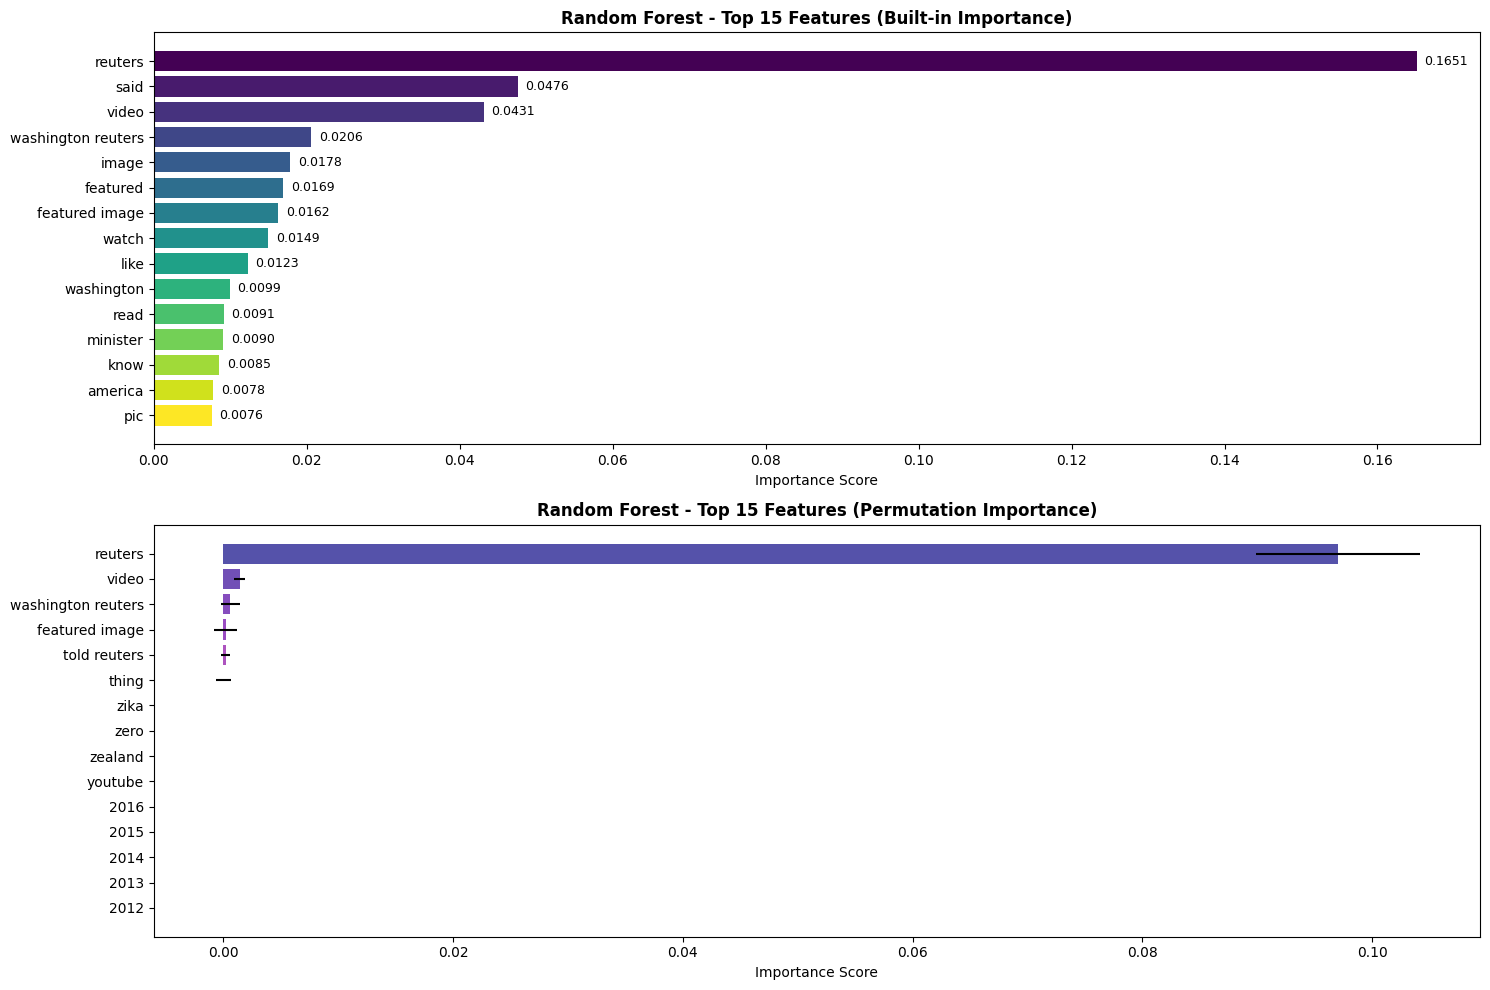


📊 STATISTICAL SIGNIFICANCE OF FEATURES
   ⚠️  Statistical significance testing currently implemented for Logistic Regression only
   For Random Forest, use built-in feature importance and permutation importance above

📋 COMPREHENSIVE STATISTICAL REPORT
🎯 MODEL PERFORMANCE SUMMARY:
   • Accuracy:  0.9981
   • Precision: 0.9976
   • Recall:    0.9983
   • F1 Score:  0.9980
   • AUC:       0.9999

📊 STATISTICAL SIGNIFICANCE:
   • Baseline (majority class): 0.5254
   • Improvement: 0.4727 (90.0%)

🔍 FEATURE ANALYSIS:
   • Total features: 5,000

💡 PRACTICAL SIGNIFICANCE:
   ✅ Model shows excellent practical utility for fake news detection
   • Model is more sensitive (higher recall, lower precision)

✅ Statistical analysis completed!
   Key findings saved in feature importance plots


In [ ]:

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import permutation_importance
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

def load_model_and_data():
    """Load the trained model and test data"""
    print("Loading model and test data...")
    
    try:
        base_dir = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        base_dir = os.getcwd()

    # ✅ Go up one level from 'notebooks' to project root
    project_root = os.path.abspath(os.path.join(base_dir, ".."))

    model_path = os.path.join(project_root, 'models', 'original_random_forest_model.pkl')
    data_path = os.path.join(project_root, 'data', 'cleaned_news_dataset.csv')

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"❌ Model file not found: {model_path}")
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"❌ Data file not found: {data_path}")

    model = joblib.load(model_path)
    df = pd.read_csv(data_path)
    
    # Prepare features
    X = df['combined_text']
    y = df['label']
    
    # Split data (same random state as modeling)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"✅ Model and data loaded")
    print(f"📊 Test set: {X_test.shape[0]:,} samples")
    print(f"🔍 Model type: {type(model.named_steps[list(model.named_steps.keys())[-1]]).__name__}")
    
    return model, X_train, X_test, y_train, y_test

def hypothesis_testing_performance(model, X_test, y_test):
    """Perform hypothesis testing on model performance"""
    print("\n" + "="*60)
    print("📊 HYPOTHESIS TESTING - MODEL PERFORMANCE")
    print("="*60)
    
    # Get predictions and probabilities
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate key metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"📈 Model Performance Metrics:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1 Score:  {f1:.4f}")
    
    # Hypothesis test: Is accuracy significantly better than random guessing?
    print(f"\n🔍 Hypothesis Test 1: Accuracy vs Random Guessing")
    
    # Random guessing baseline (majority class)
    baseline_accuracy = max(y_test.mean(), 1 - y_test.mean())
    n_test = len(y_test)
    
    # Z-test for proportions
    se = np.sqrt(baseline_accuracy * (1 - baseline_accuracy) / n_test)
    z_score = (accuracy - baseline_accuracy) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    
    print(f"   Baseline accuracy (majority class): {baseline_accuracy:.4f}")
    print(f"   Model accuracy: {accuracy:.4f}")
    print(f"   Z-score: {z_score:.4f}")
    print(f"   P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("   ✅ REJECT H0: Model performs significantly better than random guessing")
    else:
        print("   ❌ FAIL TO REJECT H0: Model not significantly better than random guessing")
    
    # Hypothesis test 2: Compare precision and recall
    print(f"\n🔍 Hypothesis Test 2: Precision vs Recall Balance")
    
    # Test if precision and recall are significantly different
    precision_recall_diff = abs(precision - recall)
    pooled_se = np.sqrt((precision * (1 - precision) + recall * (1 - recall)) / n_test)
    z_score_pr = precision_recall_diff / pooled_se
    p_value_pr = 2 * (1 - stats.norm.cdf(abs(z_score_pr)))
    
    print(f"   Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"   Absolute difference: {precision_recall_diff:.4f}")
    print(f"   P-value for difference: {p_value_pr:.4f}")
    
    if p_value_pr < 0.05:
        print("   ✅ Significant difference between precision and recall")
    else:
        print("   ❌ No significant difference between precision and recall")
    
    return y_pred, y_pred_proba

def confidence_intervals_metrics(y_test, y_pred, y_pred_proba):
    """Calculate confidence intervals for performance metrics"""
    print(f"\n" + "="*60)
    print("📊 CONFIDENCE INTERVALS FOR PERFORMANCE METRICS")
    print("="*60)
    
    # Bootstrap confidence intervals
    n_bootstraps = 500  # Reduced for speed
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    
    for i in range(n_bootstraps):
        # Bootstrap sample
        indices = resample(range(len(y_test)))
        y_test_boot = y_test.iloc[indices]
        y_pred_boot = y_pred[indices]
        
        # Calculate metrics
        metrics['accuracy'].append(accuracy_score(y_test_boot, y_pred_boot))
        metrics['precision'].append(precision_score(y_test_boot, y_pred_boot, zero_division=0))
        metrics['recall'].append(recall_score(y_test_boot, y_pred_boot))
        metrics['f1'].append(f1_score(y_test_boot, y_pred_boot))
    
    # Calculate 95% confidence intervals
    print("95% Confidence Intervals (Bootstrap):")
    for metric_name, values in metrics.items():
        ci_lower = np.percentile(values, 2.5)
        ci_upper = np.percentile(values, 97.5)
        mean_val = np.mean(values)
        print(f"   {metric_name.capitalize():10}: {mean_val:.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")
    
    # AUC confidence interval
    auc_scores = []
    for i in range(n_bootstraps):
        indices = resample(range(len(y_test)))
        auc_scores.append(roc_auc_score(y_test.iloc[indices], y_pred_proba[indices]))
    
    auc_ci_lower = np.percentile(auc_scores, 2.5)
    auc_ci_upper = np.percentile(auc_scores, 97.5)
    auc_mean = np.mean(auc_scores)
    
    print(f"   AUC        : {auc_mean:.4f} [{auc_ci_lower:.4f}, {auc_ci_upper:.4f}]")

def validate_model_assumptions(model, X_train, X_test, y_train, y_test):
    """Validate key assumptions for the model"""
    print(f"\n" + "="*60)
    print("🔍 MODEL ASSUMPTION VALIDATION")
    print("="*60)
    
    # Get the model type
    model_type = type(model.named_steps[list(model.named_steps.keys())[-1]]).__name__
    print(f"Model type: {model_type}")
    
    if model_type == 'RandomForestClassifier':
        validate_rf_assumptions(model, X_train, X_test, y_train, y_test)
    elif model_type == 'LogisticRegression':
        validate_lr_assumptions(model, X_train, X_test, y_train, y_test)
    else:
        print(f"   ⚠️  Assumption validation not implemented for {model_type}")

def validate_rf_assumptions(model, X_train, X_test, y_train, y_test):
    """Validate assumptions for Random Forest"""
    print("🌲 Random Forest Assumption Checks:")
    
    # Get the TF-IDF features and RF model
    tfidf = model.named_steps['tfidf']
    rf_model = model.named_steps['rf']
    
    # Transform the training data
    X_train_tfidf = tfidf.transform(X_train)
    
    print("1. Feature Quality Check:")
    # Check for feature importance distribution
    if hasattr(rf_model, 'feature_importances_'):
        importances = rf_model.feature_importances_
        print(f"   Number of features with importance > 0.001: {np.sum(importances > 0.001)}")
        print(f"   Top feature importance: {np.max(importances):.4f}")
        print(f"   Mean feature importance: {np.mean(importances):.6f}")
    
    print("\n2. Out-of-Bag Error Check:")
    if hasattr(rf_model, 'oob_score_'):
        print(f"   OOB Score: {rf_model.oob_score_:.4f}")
    else:
        print("   ⚠️  OOB score not available (set oob_score=True during training)")
    
    print("\n3. Tree Depth Analysis:")
    tree_depths = [tree.tree_.max_depth for tree in rf_model.estimators_]
    print(f"   Average tree depth: {np.mean(tree_depths):.1f}")
    print(f"   Max tree depth: {np.max(tree_depths)}")
    print(f"   Min tree depth: {np.min(tree_depths)}")
    
    print("\n4. Prediction Confidence Analysis:")
    y_pred_proba = model.predict_proba(X_test)
    prediction_confidence = np.max(y_pred_proba, axis=1)
    print(f"   Average prediction confidence: {np.mean(prediction_confidence):.4f}")
    print(f"   Low confidence predictions (<0.6): {np.sum(prediction_confidence < 0.6)}/{len(prediction_confidence)}")

def validate_lr_assumptions(model, X_train, X_test, y_train, y_test):
    """Validate assumptions for Logistic Regression"""
    print("📈 Logistic Regression Assumption Checks:")
    
    # Get the TF-IDF features and LR model
    tfidf = model.named_steps['tfidf']
    lr_model = model.named_steps['lr']
    
    # Transform the training data
    X_train_tfidf = tfidf.transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    print("1. Feature Independence Check:")
    from sklearn.feature_selection import mutual_info_classif
    # Use a subset for faster computation
    n_samples = min(1000, X_train_tfidf.shape[0])
    X_subset = X_train_tfidf[:n_samples].toarray()
    y_subset = y_train[:n_samples]
    
    mi_scores = mutual_info_classif(X_subset, y_subset, random_state=42)
    print(f"   Average mutual information: {np.mean(mi_scores):.4f}")
    print(f"   Max mutual information: {np.max(mi_scores):.4f}")
    
    print("\n2. Multicollinearity Check:")
    # Use smaller subset for covariance calculation
    n_samples_cov = min(500, X_train_tfidf.shape[0])
    X_cov = X_train_tfidf[:n_samples_cov].toarray()
    covariance_matrix = X_cov.T @ X_cov
    condition_number = np.linalg.cond(covariance_matrix)
    print(f"   Condition number of feature matrix: {condition_number:.2e}")
    if condition_number > 1000:
        print("   ⚠️  High condition number indicates potential multicollinearity")
    else:
        print("   ✅ Condition number within acceptable range")

def analyze_feature_importance(model, X_train, X_test, y_train, y_test, top_n=20):
    """Comprehensive feature importance analysis"""
    print(f"\n" + "="*60)
    print("🔍 FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    # Get model components
    tfidf = model.named_steps['tfidf']
    model_type = type(model.named_steps[list(model.named_steps.keys())[-1]]).__name__
    
    # Get feature names
    try:
        feature_names = tfidf.get_feature_names_out()
    except:
        feature_names = tfidf.get_feature_names()
    
    if model_type == 'RandomForestClassifier':
        return analyze_rf_feature_importance(model, X_test, y_test, feature_names, top_n)
    elif model_type == 'LogisticRegression':
        return analyze_lr_feature_importance(model, X_test, y_test, feature_names, top_n)
    else:
        print(f"   ⚠️  Feature importance not implemented for {model_type}")
        return feature_names, None, None

def analyze_rf_feature_importance(model, X_test, y_test, feature_names, top_n=20):
    """Feature importance analysis for Random Forest"""
    rf_model = model.named_steps['rf']
    tfidf = model.named_steps['tfidf']
    
    # 1. Built-in feature importance
    if hasattr(rf_model, 'feature_importances_'):
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)[-top_n:][::-1]
        
        print("Top Features by Random Forest Importance:")
        print("-" * 55)
        for i, idx in enumerate(indices[:top_n]):
            print(f"{i+1:2d}. {feature_names[idx]:20} | Importance: {importances[idx]:.4f}")
    
    # 2. Permutation importance with sparse matrix handling
    print(f"\n🔄 Calculating Permutation Importance...")
    X_test_tfidf = tfidf.transform(X_test)
    
    # Convert sparse matrix to dense array for permutation importance
    # Use a subset if the matrix is too large
    n_samples_perm = min(1000, X_test_tfidf.shape[0])
    X_test_dense = X_test_tfidf[:n_samples_perm].toarray()
    y_test_subset = y_test[:n_samples_perm]
    
    try:
        perm_importance = permutation_importance(
            rf_model, X_test_dense, y_test_subset, 
            n_repeats=5,  # Reduced for speed
            random_state=42,
            scoring='f1',
            n_jobs=-1
        )
        
        # Get top permutation importance features
        perm_indices = np.argsort(perm_importance.importances_mean)[-top_n:][::-1]
        
        print("\nTop Features by Permutation Importance:")
        print("-" * 55)
        for i, idx in enumerate(perm_indices[:10]):  # Show top 10
            if idx < len(feature_names):  # Safety check
                print(f"{i+1:2d}. {feature_names[idx]:20} | Importance: {perm_importance.importances_mean[idx]:.4f} (±{perm_importance.importances_std[idx]:.4f})")
    
    except Exception as e:
        print(f"   ⚠️  Permutation importance failed: {e}")
        perm_importance = None
        perm_indices = []
    
    # Visualization for Random Forest
    plt.figure(figsize=(15, 10))
    
    # Built-in importance plot
    plt.subplot(2, 1, 1)
    top_builtin_features = [feature_names[i] for i in indices[:15]]
    top_builtin_values = [importances[i] for i in indices[:15]]
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_builtin_features)))
    bars = plt.barh(range(len(top_builtin_features)), top_builtin_values, color=colors)
    plt.yticks(range(len(top_builtin_features)), top_builtin_features)
    plt.title('Random Forest - Top 15 Features (Built-in Importance)', fontweight='bold')
    plt.xlabel('Importance Score')
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{top_builtin_values[i]:.4f}', ha='left', va='center', fontsize=9)
    
    # Permutation importance plot (if available)
    if perm_importance is not None and len(perm_indices) > 0:
        plt.subplot(2, 1, 2)
        top_perm_features = [feature_names[i] for i in perm_indices[:15] if i < len(feature_names)]
        top_perm_values = [perm_importance.importances_mean[i] for i in perm_indices[:15] if i < len(feature_names)]
        top_perm_std = [perm_importance.importances_std[i] for i in perm_indices[:15] if i < len(feature_names)]
        
        if top_perm_features:  # Check if we have any features to plot
            colors = plt.cm.plasma(np.linspace(0, 1, len(top_perm_features)))
            bars = plt.barh(range(len(top_perm_features)), top_perm_values, 
                           xerr=top_perm_std, color=colors, alpha=0.7)
            plt.yticks(range(len(top_perm_features)), top_perm_features)
            plt.title('Random Forest - Top 15 Features (Permutation Importance)', fontweight='bold')
            plt.xlabel('Importance Score')
            plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('random_forest_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return feature_names, importances, perm_importance

def analyze_lr_feature_importance(model, X_test, y_test, feature_names, top_n=20):
    """Feature importance analysis for Logistic Regression"""
    lr_model = model.named_steps['lr']
    tfidf = model.named_steps['tfidf']
    
    # 1. Coefficient-based importance
    coefficients = lr_model.coef_[0]
    feature_importance = np.abs(coefficients)
    
    # Get top features
    top_indices = np.argsort(feature_importance)[-top_n:][::-1]
    
    print("Top Features by Coefficient Magnitude:")
    print("-" * 50)
    for i, idx in enumerate(top_indices):
        sign = "+" if coefficients[idx] > 0 else "-"
        print(f"{i+1:2d}. {feature_names[idx]:20} | Coef: {coefficients[idx]:.4f} ({sign}) | Importance: {feature_importance[idx]:.4f}")
    
    # 2. Permutation importance with sparse matrix handling
    print(f"\nCalculating permutation importance...")
    X_test_tfidf = tfidf.transform(X_test)
    
    # Convert to dense array for permutation importance
    n_samples_perm = min(1000, X_test_tfidf.shape[0])
    X_test_dense = X_test_tfidf[:n_samples_perm].toarray()
    y_test_subset = y_test[:n_samples_perm]
    
    try:
        perm_importance = permutation_importance(
            lr_model, X_test_dense, y_test_subset, 
            n_repeats=5,  # Reduced for speed
            random_state=42,
            scoring='f1'
        )
    except Exception as e:
        print(f"   ⚠️  Permutation importance failed: {e}")
        perm_importance = None
    
    # Visualization for Logistic Regression
    plt.figure(figsize=(15, 8))
    
    # Coefficient importance plot
    top_coef_features = [feature_names[i] for i in top_indices[:15]]
    top_coef_values = [coefficients[i] for i in top_indices[:15]]
    
    colors = ['green' if x > 0 else 'red' for x in top_coef_values]
    bars = plt.barh(range(15), top_coef_values, color=colors)
    plt.yticks(range(15), top_coef_features)
    plt.title('Logistic Regression - Top 15 Features\n(Green=True news, Red=Fake news)', fontweight='bold')
    plt.xlabel('Coefficient Value')
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.001 if bar.get_width() >= 0 else bar.get_width() - 0.01, 
                bar.get_y() + bar.get_height()/2, 
                f'{top_coef_values[i]:.4f}', ha='left' if bar.get_width() >= 0 else 'right', 
                va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return feature_names, coefficients, perm_importance

def statistical_significance_features(model, X_test, y_test, feature_names):
    """Test statistical significance of feature importance"""
    print(f"\n" + "="*60)
    print("📊 STATISTICAL SIGNIFICANCE OF FEATURES")
    print("="*60)
    
    model_type = type(model.named_steps[list(model.named_steps.keys())[-1]]).__name__
    
    if model_type == 'LogisticRegression':
        statistical_significance_lr_features(model, X_test, y_test, feature_names)
    else:
        print(f"   ⚠️  Statistical significance testing currently implemented for Logistic Regression only")
        print(f"   For Random Forest, use built-in feature importance and permutation importance above")

def statistical_significance_lr_features(model, X_test, y_test, feature_names):
    """Test statistical significance for Logistic Regression features"""
    tfidf = model.named_steps['tfidf']
    lr_model = model.named_steps['lr']
    
    X_test_tfidf = tfidf.transform(X_test)
    coefficients = lr_model.coef_[0]
    
    # Calculate p-values for coefficients using bootstrap (with subset for speed)
    n_bootstraps = 100  # Reduced for speed
    boot_coefs = np.zeros((n_bootstraps, len(coefficients)))
    
    from sklearn.linear_model import LogisticRegression
    
    # Use subset for bootstrap
    n_samples_boot = min(1000, X_test_tfidf.shape[0])
    X_boot_base = X_test_tfidf[:n_samples_boot].toarray()
    y_boot_base = y_test[:n_samples_boot]
    
    for i in range(n_bootstraps):
        # Bootstrap sample
        indices = resample(range(len(X_boot_base)))
        X_boot = X_boot_base[indices]
        y_boot = y_boot_base.iloc[indices] if hasattr(y_boot_base, 'iloc') else y_boot_base[indices]
        
        # Fit logistic regression on bootstrap sample
        boot_lr = LogisticRegression(random_state=42, max_iter=1000)
        boot_lr.fit(X_boot, y_boot)
        if len(boot_lr.coef_) > 0:
            boot_coefs[i] = boot_lr.coef_[0]
    
    # Calculate p-values (two-tailed test)
    p_values = []
    for j in range(len(coefficients)):
        # Count how often bootstrap coefficient has opposite sign or is zero
        opposite_sign_count = np.sum(boot_coefs[:, j] * coefficients[j] <= 0)
        p_value = opposite_sign_count / n_bootstraps
        p_values.append(p_value)
    
    p_values = np.array(p_values)
    
    # Count significant features at different levels
    alpha_levels = [0.05, 0.01, 0.001]
    print("Feature Significance at Different Alpha Levels:")
    for alpha in alpha_levels:
        significant_count = np.sum(p_values < alpha)
        print(f"   α = {alpha}: {significant_count} significant features ({significant_count/len(p_values)*100:.1f}%)")
    
    # Show most significant features
    significant_indices = np.where(p_values < 0.05)[0]
    if len(significant_indices) > 0:
        print(f"\nTop 10 Most Statistically Significant Features (p < 0.05):")
        print("-" * 60)
        top_sig_indices = significant_indices[np.argsort(p_values[significant_indices])[:10]]
        
        for i, idx in enumerate(top_sig_indices):
            if idx < len(feature_names):  # Safety check
                print(f"{i+1:2d}. {feature_names[idx]:20} | Coef: {coefficients[idx]:.4f} | p-value: {p_values[idx]:.4f}")

def create_comprehensive_report(model, X_test, y_test, y_pred, y_pred_proba):
    """Create a comprehensive statistical report"""
    print(f"\n" + "="*60)
    print("📋 COMPREHENSIVE STATISTICAL REPORT")
    print("="*60)
    
    # Model performance summary
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    print("🎯 MODEL PERFORMANCE SUMMARY:")
    print(f"   • Accuracy:  {accuracy:.4f}")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall:    {recall:.4f}")
    print(f"   • F1 Score:  {f1:.4f}")
    print(f"   • AUC:       {auc_score:.4f}")
    
    # Statistical significance conclusion
    baseline_accuracy = max(y_test.mean(), 1 - y_test.mean())
    improvement = accuracy - baseline_accuracy
    improvement_pct = (improvement / baseline_accuracy) * 100
    
    print(f"\n📊 STATISTICAL SIGNIFICANCE:")
    print(f"   • Baseline (majority class): {baseline_accuracy:.4f}")
    print(f"   • Improvement: {improvement:.4f} ({improvement_pct:.1f}%)")
    
    # Feature analysis insights
    tfidf = model.named_steps['tfidf']
    try:
        n_features = len(tfidf.get_feature_names_out())
    except:
        n_features = len(tfidf.get_feature_names())
    
    print(f"\n🔍 FEATURE ANALYSIS:")
    print(f"   • Total features: {n_features:,}")
    
    # Practical significance
    print(f"\n💡 PRACTICAL SIGNIFICANCE:")
    if accuracy > 0.85:
        print("   ✅ Model shows excellent practical utility for fake news detection")
    elif accuracy > 0.75:
        print("   ⚠️  Model shows good practical utility with room for improvement")
    else:
        print("   ❌ Model may have limited practical utility")
    
    if precision > recall:
        print("   • Model is more conservative (higher precision, lower recall)")
    else:
        print("   • Model is more sensitive (higher recall, lower precision)")

def main():
    """Main function for statistical analysis"""
    print("=" * 60)
    print("📊 STATISTICAL ANALYSIS & EVALUATION")
    print("=" * 60)
    
    # Load model and data
    model, X_train, X_test, y_train, y_test = load_model_and_data()
    
    # 1. Hypothesis testing
    y_pred, y_pred_proba = hypothesis_testing_performance(model, X_test, y_test)
    
    # 2. Confidence intervals
    confidence_intervals_metrics(y_test, y_pred, y_pred_proba)
    
    # 3. Model assumption validation
    validate_model_assumptions(model, X_train, X_test, y_train, y_test)
    
    # 4. Feature importance analysis
    feature_names, coefficients, perm_importance = analyze_feature_importance(
        model, X_train, X_test, y_train, y_test
    )
    
    # 5. Statistical significance of features
    statistical_significance_features(model, X_test, y_test, feature_names)
    
    # 6. Comprehensive report
    create_comprehensive_report(model, X_test, y_test, y_pred, y_pred_proba)
    
    print(f"\n✅ Statistical analysis completed!")
    print(f"   Key findings saved in feature importance plots")

if __name__ == "__main__":
    main()